In [1]:
# Core Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Settings
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")


In [2]:
df = pd.read_csv("/content/customer_shopping_data.csv")

print(df.shape)
df.head()


(99457, 10)


,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


In [3]:
# Convert date
df['invoice_date'] = pd.to_datetime(df['invoice_date'], dayfirst=True)

# Remove invalid rows
df.dropna(inplace=True)
df = df[df['quantity'] > 0]
df = df[df['price'] > 0]

# Feature: Total Spend (price already represents total)
df['total_spend'] = df['price']

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   invoice_no      99457 non-null  object        
 1   customer_id     99457 non-null  object        
 2   gender          99457 non-null  object        
 3   age             99457 non-null  int64         
 4   category        99457 non-null  object        
 5   quantity        99457 non-null  int64         
 6   price           99457 non-null  float64       
 7   payment_method  99457 non-null  object        
 8   invoice_date    99457 non-null  datetime64[ns]
 9   shopping_mall   99457 non-null  object        
 10  total_spend     99457 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 8.3+ MB


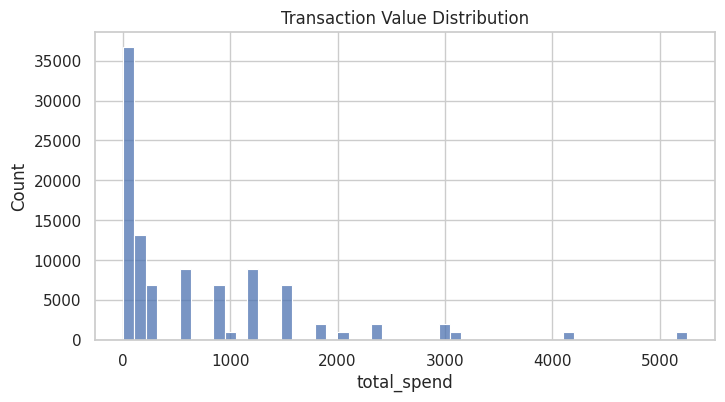

In [4]:
plt.figure(figsize=(8,4))
sns.histplot(df['total_spend'], bins=50)
plt.title("Transaction Value Distribution")
plt.show()


**Most customers buy small quantities or low-priced items, but a small subset makes large purchases that drive a disproportionate share of revenue**

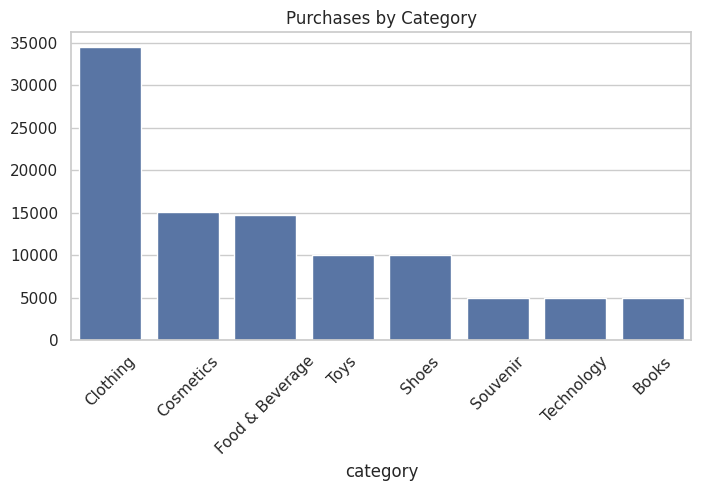

In [5]:
plt.figure(figsize=(8,4))
sns.barplot(x=df['category'].value_counts().index,
            y=df['category'].value_counts().values)
plt.xticks(rotation=45)
plt.title("Purchases by Category")
plt.show()


In [6]:
snapshot_date = df['invoice_date'].max() + pd.Timedelta(days=1)

rfm = df.groupby('customer_id').agg({
    'invoice_date': lambda x: (snapshot_date - x.max()).days,
    'invoice_no': 'nunique',
    'total_spend': 'sum',
    'quantity': 'sum',
    'age': 'mean'
})

rfm.columns = ['Recency', 'Frequency', 'Monetary', 'TotalQuantity', 'AvgAge']

rfm.head()


,Recency,Frequency,Monetary,TotalQuantity,AvgAge
customer_id,,,,,
C100004,468,1,1500.40,5,61.0
C100005,6,1,1200.34,2,34.0
C100006,98,1,107.52,3,44.0
C100012,571,1,26.15,5,25.0
C100019,592,1,35.84,1,21.0


In [7]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


Selecting the number of clusters

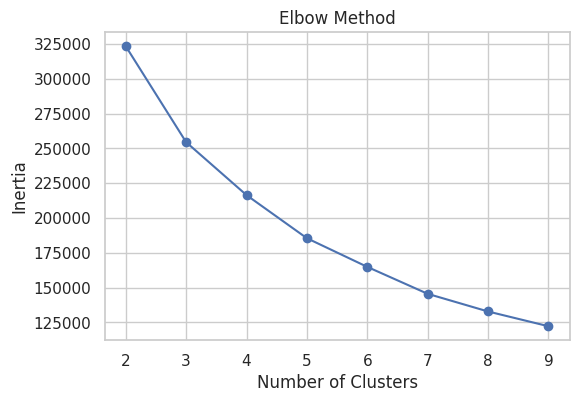

In [8]:
inertia = []

for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(range(2,10), inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


In [9]:
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(rfm_scaled)
    print(f"k={k}, silhouette={silhouette_score(rfm_scaled, labels):.3f}")


k=2, silhouette=0.197
k=3, silhouette=0.218
k=4, silhouette=0.212
k=5, silhouette=0.231
k=6, silhouette=0.224


In [10]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

rfm['Cluster'].value_counts()


,count
Cluster,
3,31647
1,26084
0,26078
2,15648


In [11]:
cluster_profile = rfm.groupby('Cluster').mean().round(2)
cluster_profile


,Recency,Frequency,Monetary,TotalQuantity,AvgAge
Cluster,,,,,
0,544.46,1.0,388.95,2.72,57.82
1,555.52,1.0,397.85,2.79,29.47
2,381.46,1.0,2339.54,4.44,43.68
3,155.30,1.0,360.91,2.70,42.95


In [12]:
cluster_labels = {
    0: "Inactive – Older Low Value",
    1: "Young – Low Engagement",
    2: "High Value Customers (VIP)",
    3: "Active Regular Customers"
}

rfm['Segment'] = rfm['Cluster'].map(cluster_labels)


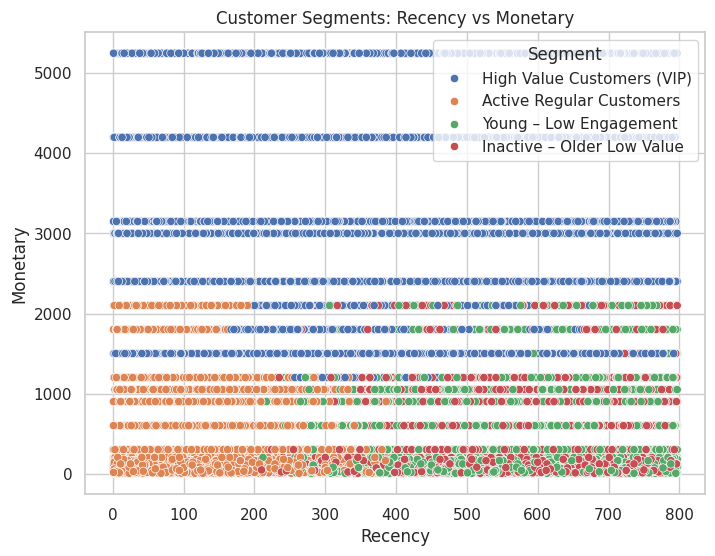

In [13]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=rfm,
    x="Recency",
    y="Monetary",
    hue="Segment"
)
plt.title("Customer Segments: Recency vs Monetary")
plt.show()


In [14]:
df_segmented = df.merge(
    rfm[['Segment']], left_on='customer_id', right_index=True
)

category_segment = (
    df_segmented.groupby(['Segment', 'category'])['total_spend']
    .sum()
    .reset_index()
)

category_segment.head()


,Segment,category,total_spend
0,Active Regular Customers,Books,88385.10
1,Active Regular Customers,Clothing,7164710.08
2,Active Regular Customers,Cosmetics,716063.26
3,Active Regular Customers,Food & Beverage,87853.54
4,Active Regular Customers,Shoes,2033375.96


from matplotlib import pyplot as plt
_df_0['total_spend'].plot(kind='hist', bins=20, title='total_spend')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['total_spend'].plot(kind='line', figsize=(8, 4), title='total_spend')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_3['category'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_3, x='total_spend', y='category', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [15]:
X = rfm[['Recency', 'Frequency', 'TotalQuantity']]
y = rfm['Monetary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

rfm['Predicted_CLV'] = model.predict(X)


In [16]:
rfm['Churn_Risk'] = np.where(
    (rfm['Recency'] > rfm['Recency'].quantile(0.75)) &
    (rfm['Frequency'] == 1),
    "High Risk",
    "Low Risk"
)


In [17]:
final_df = rfm.reset_index()

final_df.head()


,customer_id,Recency,Frequency,Monetary,TotalQuantity,AvgAge,Cluster,Segment,Predicted_CLV,Churn_Risk
0,C100004,468,1,1500.40,5,61.0,2,High Value Customers (VIP),1140.900745,Low Risk
1,C100005,6,1,1200.34,2,34.0,3,Active Regular Customers,459.301891,Low Risk
2,C100006,98,1,107.52,3,44.0,3,Active Regular Customers,686.728077,Low Risk
3,C100012,571,1,26.15,5,25.0,1,Young – Low Engagement,1140.524348,Low Risk
4,C100019,592,1,35.84,1,21.0,1,Young – Low Engagement,229.398066,Low Risk


In [18]:

category_segment.to_csv("Category_Segment_Insights.csv", index=False)


In [19]:
def recommend_offer(row):
    if row['Segment'] == "High Value Customers (VIP)":
        return "Exclusive loyalty rewards & early product access"

    elif row['Segment'] == "Active Regular Customers":
        return "Personalized product bundles & upsell offers"

    elif row['Segment'] == "Young – Low Engagement":
        return "Discount coupons & gamified rewards"

    elif row['Churn_Risk'] == "High Risk":
        return "Win-back offers & reactivation discounts"

    else:
        return "Standard promotions"

rfm['Recommended_Action'] = rfm.apply(recommend_offer, axis=1)


In [21]:
final_output = rfm.reset_index()[[
    'customer_id',
    'Segment',
    'Monetary',
    'Predicted_CLV',
    'Churn_Risk',
    'Recommended_Action'
]]

final_output.head()

,customer_id,Segment,Monetary,Predicted_CLV,Churn_Risk,Recommended_Action
0,C100004,High Value Customers (VIP),1500.40,1140.900745,Low Risk,Exclusive loyalty rewards & early product access
1,C100005,Active Regular Customers,1200.34,459.301891,Low Risk,Personalized product bundles & upsell offers
2,C100006,Active Regular Customers,107.52,686.728077,Low Risk,Personalized product bundles & upsell offers
3,C100012,Young – Low Engagement,26.15,1140.524348,Low Risk,Discount coupons & gamified rewards
4,C100019,Young – Low Engagement,35.84,229.398066,Low Risk,Discount coupons & gamified rewards


In [22]:
final_output.to_csv("AI_Customer_Intelligence_with_Churn.csv", index=False)
